# Template for Homework 2, EE 277

In [1]:
#@title imports 

import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## Problem 1: XOR Logistic Bandit

### Part 0: XOR Logistic Bandit Environment

In this part, we implement the XOR function and the XOR logistic bandit environment.

**You do not need to modify the code in this part.**



In [2]:
""" XOR function"""

def XOR(x, y):
  if (x == 0 and y == 1) or (x==1 and y==0):
    return 1
  else:
    return 0

In [3]:
""" The environment for XOR logistic bandit"""

class XORLogisticBandit:

  """
  The constructor samples an XOR logistic bandit environment
  where
  1) num_actions is the number of actions (K in the problem statement)
  2) dim is the feature dimension (N in the problem statement)
  3) the prior distribution for theta is N(0, sigma^2 I)
  """
  def __init__(self, num_actions, dim, sigma_p):

    # number of actions
    self.num_actions = num_actions

    # feature dimension
    self.dim = dim

    # sample theta and generate environment
    self.sigma_p = sigma_p
    self.sigma_p_squared = sigma_p**2

    # theta (to be learned)
    self.theta = sigma_p * np.random.randn(dim)

    # feature matrix, feature.shape=(num_actions, dim)
    feature = np.random.randn(num_actions, dim)
    self.feature = feature/np.linalg.norm(feature, axis=-1, keepdims=True)

    exp_logits = np.exp(np.tensordot(self.feature, \
                                     self.theta, axes=([-1], [0])))

    # expected reward for all context-action pairs
    # self.rewards.shape = (num_actions)
    self.p = exp_logits/(1 + exp_logits)
    self.rewards = 2 * np.multiply(self.p, 1-self.p)

    # values (optimal reward at each context)
    # self.values.shape = (1)
    self.values = np.max(self.rewards, axis=0, keepdims=True)

    # expected instantanesou regret for all context-action pairs
    # self.regrets.shape = (num_actions)
    self.regrets = self.values - self.rewards

  # return the feature matrix of the environment
  def get_feature(self):
    return self.feature

  # agents choose actions by calling this method
  def act(self, action):

    # assert that action is in the right range
    assert action >= 0 and action < self.num_actions

    # the instantaneous regret 
    inst_regret = self.regrets[action]

    # probability of observing 1
    p_1 = self.p[action]
    obs = (np.random.binomial(1, p_1), np.random.binomial(1, p_1))

    # reward, which is XOR of the two observations
    reward = XOR(obs[0], obs[1])

    # returns observation, realized reward, and inst_regret
    return obs, reward, inst_regret

### Part a: Epsilon-Greedy Agent

**You need to implement the select_action method for epsilon-greedy agent.**

**Technical Issue:** In case you are interested, we use LogisticRegression module from sklearn to solve the logistic regression. LogisticRegression module requires data with both observation 0 and observation 1. Thus, the agent will start solving logistic regressions once it has seen at least one obervation 0 and one observation 1.



In [16]:
class EpsilonGreedyAgent:

  # environment is an XORLogisticBandit
  def __init__(self, env):
    self.env = env
    self.num_actions = self.env.num_actions
    self.dim = self.env.dim
    self.sigma_p_squared = self.env.sigma_p_squared

    # the logistic regression solver
    # notice that the choice of L2 penelty and C adds a quadratic regularization
    # term corresponding to the prior
    # we do not need an intercept in the logistic regression model
    # warm_start will use the previous solution as the starting point, which 
    # will speed up learning
    self.solver = LogisticRegression(penalty='l2', 
                                     C=(2*self.sigma_p_squared),
                                     fit_intercept=False,
                                     warm_start=True)
    

  ## theta_est: the current point estimate of theta
  ## theta_est.shape = (dim)
  ## epsilon is the epsilon in epsilon-greedy algorithms
  ## phi is a matrix encoding the action features
  ## phi.shape = (num_actions, dim)
  def select_action(self, theta_est, epsilon, phi):
    ############### Start of Code Modification ################################
    ### Please implement the action selection strategy for epsilon-greedy agent
    ###########################################################################
    if np.random.rand() < epsilon:  # explore
        return np.random.randint(low=0, high=self.num_actions)
    else:  # exploit
        action_potentials = np.abs(phi @ theta_est)
        return np.argmin(action_potentials)
    ################### End of Code Modification ##############################
  
  def run(self, horizon=50, epsilon=0.05, verbose=False):
    """run simulation."""

    # placeholder for the results
    regret_vec = np.zeros(horizon)
    cum_regret = 0

    # placeholder for used features and observed rewards
    X = np.zeros((2*horizon, self.dim))
    y = np.zeros(2*horizon)

    # initial estimated theta
    theta_est = np.zeros(self.dim)

    # initialization_phase will be false once we observe both 
    # an observation 0 and an observation 1
    initialization_phase = True

    # get features
    phi = self.env.get_feature()

    for t in range(horizon):

      # select action based on epsilon-greedy
      action = self.select_action(theta_est, epsilon, phi)

      # apply the chosen action
      obs, reward, inst_regret  = self.env.act(action)

      # update regret
      regret_vec[t] = inst_regret
      cum_regret += inst_regret

      # update the placeholder
      X[2*t,:] = phi[action, :]; X[2*t+1,:] = phi[action, :];
      y[2*t] = obs[0]; y[2*t+1] = obs[1]

      if verbose and (t+1)%100==0:
        print("Epsilon-Greedy Agent: the cum regret by t={} is {}".format(t, cum_regret))

      # check if we have observations with both reward 0 and 1
      if initialization_phase and len(np.unique(y[:(t+1)])) == 2:
        initialization_phase = False
        if verbose:
          print("Initialization Phase ends in time step {}".format(t))
        
      if not initialization_phase:
        # run logistic regression and obtain the learned theta
        self.solver.fit(X[:(2*t+2),:], y[:(2*t+2)])
        theta_est = self.solver.coef_.reshape(self.dim)

    return regret_vec

### Part b: Approximate Thompson Sampling Agent Based on Laplace Approximation

**You need to implement the select_action method for Gaussian approximate Thompson sampling agent.**

In [17]:
'''
This function computes the inverse Hessian matrix of the loss function
theta.shape = (dim)
X.shape = (num_samples, dim)
'''
def getInvHessian(theta, X, sigma_p_squared):

  H = np.eye(len(theta))/sigma_p_squared

  if X.shape[0] > 0:
    logits = np.dot(X, theta)
    tmp = np.exp(logits); y_pred = np.divide(tmp, 1+tmp)
    D = np.diag(np.multiply(y_pred, 1-y_pred))

    H += np.dot(np.dot(X.T, D), X) 

  return np.linalg.inv(H)


class ApproximateTSAgent:

  # environment is an XORLogisticBandit
  def __init__(self, env):
    self.env = env
    self.num_actions = self.env.num_actions
    self.dim = self.env.dim
    self.sigma_p_squared = self.env.sigma_p_squared

    # the logistic regression solver
    # notice that the choice of L2 penelty and C adds a quadratic regularization
    # term corresponding to the prior
    # we do not need an intercept in the logistic regression model
    # warm_start will use the previous solution as the starting point, which 
    # will speed up learning
    self.solver = LogisticRegression(penalty='l2', 
                                     C=(2*self.sigma_p_squared),
                                     fit_intercept=False,
                                     warm_start=True)
    

  ## mu is the mean of Gaussian approximation
  ## mu.shape = (dim)
  ## Sigma is the covariance matrix of Gaussian approximation
  ## Sigma.shape = (dim, dim)
  ## phi is a matrix encoding the action features
  ## phi.shape = (num_actions, dim)
  def select_action(self, mu, Sigma, phi):
    ############### Start of Code Modification ################################
    ### Please implement the action selection strategy for approximate TS
    ### agent
    ###########################################################################
    theta = np.random.multivariate_normal(mu, Sigma)
    action_potentials = np.abs(phi @ theta)
    return np.argmin(action_potentials)
    ################### End of Code Modification ##############################
  
  def run(self, horizon=50, verbose=False):
    """run simulation."""

    # placeholder for the results
    regret_vec = np.zeros(horizon)
    cum_regret = 0

    # placeholder for used features and observed rewards
    X = np.zeros((2*horizon, self.dim))
    y = np.zeros(2*horizon)

    # initial mu and Sigma
    mu = np.zeros(self.dim)
    Sigma = self.sigma_p_squared*np.eye(self.dim)

    # initialization_phase will be false once we observe both a reward 0 and
    # a reward 1
    initialization_phase = True

    # get features
    phi = self.env.get_feature()

    for t in range(horizon):

      # select action based on epsilon-greedy
      action = self.select_action(mu, Sigma, phi)

      # apply the chosen action
      obs, reward, inst_regret  = self.env.act(action)

      # update regret
      regret_vec[t] = inst_regret
      cum_regret += inst_regret

      # update the placeholder
      X[2*t,:] = phi[action, :]; X[2*t+1,:] = phi[action, :];
      y[2*t] = obs[0]; y[2*t+1] = obs[1]

      if verbose and (t+1)%100==0:
        print("Laplace Agent: the cum regret by t={} is {}".format(t, cum_regret))

      # check if we have observations with both reward 0 and 1
      if initialization_phase and len(np.unique(y[:(t+1)])) == 2:
        initialization_phase = False
        if verbose:
          print("Initialization Phase ends in time step {}".format(t))
        
      if not initialization_phase:
        # run logistic regression and obtain the learned theta
        self.solver.fit(X[:(2*t+2),:], y[:(2*t+2)])
        mu = self.solver.coef_.reshape(self.dim)

        # compute the covariance matrix
        Sigma = getInvHessian(mu, X[:(2*t+2),:], self.sigma_p_squared)

    return regret_vec

### Part d: Show Results

**You do not need to modify the code below. You just need to run it to generate the plot for the cumulative regrets.**

In [21]:
# function to run the experiments
def compareAgents(seed_vec, num_actions, dim, horizon, sigma_p=1):

  # placeholders for the results
  regret_matrix_eps_greedy = np.zeros((len(seed_vec), horizon))
  regret_matrix_laplace = np.zeros((len(seed_vec), horizon))

  # loop over the random seeds
  for i in range(len(seed_vec)):

    np.random.seed(seed_vec[i])
    print('For seed={} with horizon {}, the total regrets are:'.format(seed_vec[i], horizon))

    # randomly sample one environment
    env = XORLogisticBandit(num_actions = num_actions,
                        dim = dim, sigma_p = sigma_p)
    
    # epsilon-greedy agent
    agent_epsilon = EpsilonGreedyAgent(env)
    regret_matrix_eps_greedy[i,:] = agent_epsilon.run(horizon=horizon, epsilon=0.05)
    print('Epsilon-Greedy: {}'.format(np.sum(regret_matrix_eps_greedy[i, :])))

    # approximate Thompson sampling agent
    agent_laplace = ApproximateTSAgent(env)
    regret_matrix_laplace[i,:] = agent_laplace.run(horizon=horizon)
    print('Approximate TS: {}'.format(np.sum(regret_matrix_laplace[i, :])))

  # compute the mean cumulative regrets
  cum_regret = {}
  cum_regret['epsilon-greedy'] = np.cumsum(np.mean(regret_matrix_eps_greedy, axis=0))
  cum_regret['ats'] = np.cumsum(np.mean(regret_matrix_laplace, axis=0))

  return cum_regret

In [24]:
## Experiment set up

# 10 simulations, with random seed = 0,1, ... 9
seed_vec = range(10)

# 100 actions
num_actions = 100

# feature dimension is 3
dim = 3

# time horizon is 1000
horizon = 1000

# run the simulations
cum_regret = compareAgents(seed_vec, num_actions, dim, horizon)

For seed=0 with horizon 1000, the total regrets are:
Epsilon-Greedy: 8.839077695401413
Approximate TS: 5.0925457981886515
For seed=1 with horizon 1000, the total regrets are:
Epsilon-Greedy: 10.670136734257305
Approximate TS: 6.197358753805368
For seed=2 with horizon 1000, the total regrets are:
Epsilon-Greedy: 10.69060677788329
Approximate TS: 5.093673438087084
For seed=3 with horizon 1000, the total regrets are:
Epsilon-Greedy: 9.034895901633181
Approximate TS: 5.508309893816031
For seed=4 with horizon 1000, the total regrets are:
Epsilon-Greedy: 3.3681171663960927
Approximate TS: 5.262853726787965
For seed=5 with horizon 1000, the total regrets are:
Epsilon-Greedy: 12.429480310983504
Approximate TS: 8.83577648403709
For seed=6 with horizon 1000, the total regrets are:
Epsilon-Greedy: 5.4380853167136
Approximate TS: 3.984941716241779
For seed=7 with horizon 1000, the total regrets are:
Epsilon-Greedy: 8.006628720154977
Approximate TS: 5.819723148053136
For seed=8 with horizon 1000, t

Text(0, 0.5, 'cumulative regret')

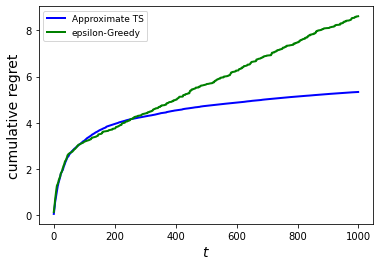

In [25]:
  ## generate the plot for the cumulative regrets
  
  time_vec = range(horizon)
  plt.figure(1)
  plt.clf()

  plt.plot(time_vec, cum_regret['ats'], color='b', 
         linewidth=2, label='Approximate TS')

  plt.plot(time_vec, cum_regret['epsilon-greedy'], color='g', 
         linewidth=2, label='epsilon-Greedy')

  plt.legend(loc="best", fontsize=9)
  plt.xlabel("$t$", fontsize=14)
  plt.ylabel("cumulative regret", fontsize=14)

## Problem 2: Contextual Recommendation

### Part a.1: the Contextual Recommendation Environment

In this part, we implement the environment for the contextual recommendation problem.

**You do not need to modify the code of this part.**

In [26]:
class RecEnv:

  # constructor
  def __init__(self):

    # set the attraction probabilities
    self.attraction_probs = np.array([[0.3, 0.1, 0.25, 0.15], 
                                      [0.1, 0.3, 0.25, 0.15]])
    
    # the number of user types
    self.num_user_type = 2

    # the number of genres
    self.num_genre = 4

    # compute the instantaneous regret for each context-action pair
    self.values = np.max(self.attraction_probs, axis=1, keepdims=True)
    self.regret = self.values - self.attraction_probs
    
  def act(self, action, t):

    # time t=0, when the action is non-essential
    if t == 0:
      reward = 0
      inst_regret =0 

    # time t>=1
    else:
      p = self.attraction_probs[self.user_type, action]
      reward = np.random.binomial(1, p)
      inst_regret = self.regret[self.user_type, action]

    # sample user type (context) for next time step
    self.user_type = np.random.randint(low=0, high=self.num_user_type)

    return self.user_type, reward, inst_regret

### Part a.2: Agents

In this part, we implement the Thompson sampling agents Agent_1 and Agent_2 as described in the problem. 

You need to add some code in the run function.

In [27]:
"""Agent_1: which uses the contextual information."""

class Agent_1:

  # constructor
  def __init__(self, env):

    # set the environment
    self.env = env

    # number of user types
    self.num_user_type = self.env.num_user_type

    # number of genres
    self.num_genre = self.env.num_genre

  # call this function to run the experiments
  # horizon is the time horizon
  # num_sim is the number of simulations
  def run(self, horizon, num_sim=1):

    # placeholder for the results
    reward_matrix = np.zeros((num_sim, horizon))
    regret_matrix = np.zeros((num_sim, horizon))

    for s in range(num_sim):

      # initialize the alpha matrix and the beta matrix for Thompson sampling
      alpha_matrix = np.ones((self.num_user_type, self.num_genre))
      beta_matrix = np.ones((self.num_user_type, self.num_genre))

      for t in range(horizon):

        if t == 0:
          # choose arbitrary action
          action = 0
          
        else:
          ############### Start of Code Modification ##########################
          ### Delete "pass" and Write Code to choose action; 
          ### 2 to 4 lines of code expected 
          theta = np.random.beta(alpha_matrix, beta_matrix)
          action = np.argmax(theta[context])
        ################### End of Code Modification ########################

        next_context, reward, inst_regret = self.env.act(action, t=t)

        reward_matrix[s, t] = reward
        regret_matrix[s, t] = inst_regret

        if t>0:
          ############### Start of Code Modification ##########################
          ### Delete "pass" and Write Code to update alpha_matrix and 
          ### beta_matrix based on context, action, and reward
          ### 2 to 4 lines of code expected
          if reward == 1:
            alpha_matrix[context][action] += 1
          else:
            beta_matrix[context][action] += 1
          ################### End of Code Modification ########################

        # update context as the next_context
        context = next_context

    # compute the mean cumulative reward and regret
    cum_reward_mean = np.cumsum(np.mean(reward_matrix, axis=0))
    cum_regret_mean = np.cumsum(np.mean(regret_matrix, axis=0))

    return cum_reward_mean, cum_regret_mean

In [28]:
"""Agent_2: which ignores the contextual information"""

class Agent_2:

  # constructor
  def __init__(self, env):

    # set the environment
    self.env = env

    # number of genres
    self.num_genre = self.env.num_genre

  # call this function to run the experiments
  # horizon is the time horizon
  # num_sim is the number of simulations
  def run(self, horizon, num_sim=1):

    # placeholder for the results
    reward_matrix = np.zeros((num_sim, horizon))
    regret_matrix = np.zeros((num_sim, horizon))

    for s in range(num_sim):

      # initialize the alpha matrix and the beta matrix for Thompson sampling
      alpha_vec = np.ones(self.num_genre)
      beta_vec = np.ones(self.num_genre)

      for t in range(horizon):

        if t == 0:
          # choose arbitrary action
          action = 0
        else:
          ############### Start of Code Modification ##########################
          ### Delete "pass" and Write Code to choose action; 
          ### 2 to 4 lines of code expected 
          theta = np.random.beta(alpha_vec, beta_vec)
          action = np.argmax(theta)
          ################### End of Code Modification ########################

        # apply action, and observe the reward
        _, reward, inst_regret = self.env.act(action, t=t)
          
        reward_matrix[s, t] = reward
        regret_matrix[s, t] = inst_regret

        if t>0:
          ############### Start of Code Modification ##########################
          ### Delete "pass" and Write Code to update alpha_vec and beta_vec  
          ### based on action, and reward
          ### 2 to 4 lines of code expected
          if reward == 1:
            alpha_vec[action] += 1
          else:
            beta_vec[action] += 1
          ################### End of Code Modification ########################

    # compute the mean cumulative reward and regret
    cum_reward_mean = np.cumsum(np.mean(reward_matrix, axis=0))
    cum_regret_mean = np.cumsum(np.mean(regret_matrix, axis=0))
    return cum_reward_mean, cum_regret_mean

### Part a.3: Show Results

You do not need to modify the code below. You just need to run them to generate plots for cumulative rewards and cumulative regrets.

In [29]:
# set up the environment and the agent
env = RecEnv()
agent_1 = Agent_1(env)
agent_2 = Agent_2(env)

# number of simulations
num_sim = 100

# time horizon
horizon = 5000

# run agent_1
cum_reward_agent_1, cum_regret_agent_1 = agent_1.run(horizon=horizon, num_sim=num_sim)

# run agent_2
cum_reward_agent_2, cum_regret_agent_2 = agent_2.run(horizon=horizon, num_sim=num_sim)

Text(0, 0.5, 'cumulative reward')

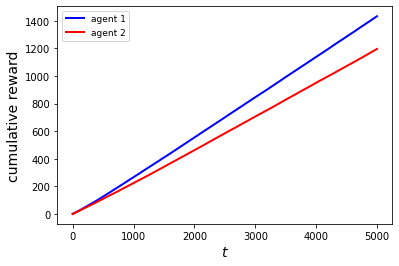

In [30]:
# plot the cumulative reward

plt.figure(2)
t_vec = range(horizon)

plt.plot(t_vec, cum_reward_agent_1, color='b', linewidth=2, label='agent 1')
plt.plot(t_vec, cum_reward_agent_2, color='r', linewidth=2, label='agent 2')

plt.legend(loc="best", fontsize=9)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("cumulative reward", fontsize=14)

Text(0, 0.5, 'cumulative regret')

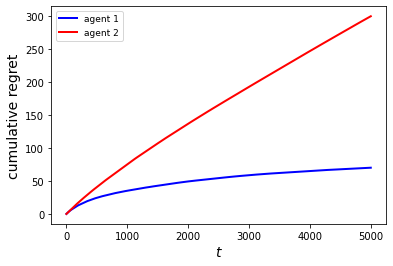

In [31]:
# plot the cumulative regret

plt.figure(3)
t_vec = range(horizon)

plt.plot(t_vec, cum_regret_agent_1, color='b', linewidth=2, label='agent 1')
plt.plot(t_vec, cum_regret_agent_2, color='r', linewidth=2, label='agent 2')

plt.legend(loc="best", fontsize=9)
plt.xlabel("$t$", fontsize=14)
plt.ylabel("cumulative regret", fontsize=14)

## Problem 3: Features for Logistic bandit

## Problem 4: Online Crowdsourcing

### Part c.1: the Online Crowdsourcing Environment

In [33]:
#@title Crowdsourcing environment

class CrowdsourcingEnv:

  def __init__(self, M: int, L: int, q: float):
    """Constructor."""

    assert L < M
    self.M = M
    self.L = L

    self.q = q

    self.p = np.random.beta(1, 1, M)

    assert len(self.p) == M

  def get_question(self):
    """get a question."""

    if np.random.binomial(1, self.q) == 1:
      self.correct_answer = 'Yes'
      self.wrong_answer = 'No'
    else:
      self.correct_answer = 'No'
      self.wrong_answer = 'Yes'


  def get_answers(self, selected_participants):
    """get participants' answers, where selected_participants is a list of integers, and each integer corresponds to a participant."""

    assert len(selected_participants) == self.L
    answers = {}

    for participant in selected_participants:

      # ensure that the participant is an integer
      participant = int(participant)

      # whether or not the participant's answer is correct
      correct_prob = self.p[participant]
      correct = np.random.binomial(1, correct_prob)

      # append the participant's answer to answers
      if correct:
        answers[participant] = self.correct_answer
      else:
        answers[participant] = self.wrong_answer

    return answers

  def get_correct_answer_and_reward(self, answer):
    """get correct answer and reward based on the agent's answer."""

    if answer == self.correct_answer:
      return self.correct_answer, 1
    else:
      return self.correct_answer, 0

### Part c.2: the Thompson sampling agent

In [38]:
#@title Thompson sampling agent for online crowdsourcing

class TS4CrowdSourcing:

  def __init__(self, env):

    self.env = env

    self.M = env.M
    self.L = env.L

    self.q = env.q

  # call this function to run the experiments
  # horizon is the time horizon
  # num_sim is the number of simulations
  def run(self, horizon, num_sim=1):

    # placeholder for the results
    reward_matrix = np.zeros((num_sim, horizon))

    for s in range(num_sim):

      # initialize the alpha matrix and the beta matrix for Thompson sampling
      alpha_vec = np.ones(self.M)
      beta_vec = np.ones(self.M)

      for t in range(horizon):

        # sample a vector of p's
        p_vec = np.random.beta(alpha_vec, beta_vec)

        self.env.get_question()

        ############### Start of Code Modification ##########################
        ### Write Code to select L participants; 2 to 4 lines of code expected
        selected_participants = np.argsort(-p_vec)[:self.L].tolist()
        ################### End of Code Modification ########################

        participant_answers = self.env.get_answers(selected_participants)

        ############### Start of Code Modification ##########################
        ### Write Code to select the agent's answer based on participants' answers; 
        ### 8-15 lines of code expected
        sum_potential = sum(p_vec[user] for user in selected_participants)
        print(sum_potential)
        print(participant_answers[selected_participants[0]])
        weighted_answer = sum(
          p_vec[user] * participant_answers[user] for user in selected_participants
        )
        agent_answer = weighted_answer / sum_potential
        ################### End of Code Modification ########################

        correct_answer, reward = self.env.get_correct_answer_and_reward(agent_answer)

        # update posterior
        for i in range(self.L):
          participant = selected_participants[i]

          if participant_answers[participant] == correct_answer:
            alpha_vec[participant] += 1
          else:
            beta_vec[participant] += 1

        reward_matrix[s,t] = reward

    # compute the mean per-step reward 
    reward_mean = np.mean(reward_matrix, axis=0)
    return reward_mean



### Part c.3: Show Results

In [39]:
#@title Experiment setup

M = 20
L = 3

q = 0.55

horizon = 1000
num_sim = 500

env = CrowdsourcingEnv(M, L, q)
agent = TS4CrowdSourcing(env)
reward_mean = agent.run(horizon, num_sim)

Yes


TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [ ]:
#@title Plot the results

plt.plot(range(horizon), reward_mean, linewidth=2)

plt.xlabel("$t$", fontsize=14)
plt.ylabel("per-step reward", fontsize=14)